In [6]:
%matplotlib inline

In [4]:
import pandas
import numpy as np

In [2]:
level = pandas.read_csv('calibration_level.csv')
level.head()

,mag_x,mag_y,mag_z,acc_x,acc_y,acc_z
0,-1168,2031,876,1440,629,-14659
1,-1168,2031,876,1563,582,-14637
2,-1163,2033,865,1409,617,-14679
3,-1168,2037,871,1386,600,-14799
4,-1168,2037,871,1427,665,-14605


In [3]:
roll = pandas.read_csv('calibration_roll.csv')
roll.head()

,mag_x,mag_y,mag_z,acc_x,acc_y,acc_z
0,-1621,1022,1268,2066,6875,-13281
1,-1621,1022,1268,1996,6899,-13217
2,-1623,1048,1272,1912,6748,-13086
3,-1604,1127,1257,2088,6105,-13354
4,-1604,1127,1257,2017,5797,-13446


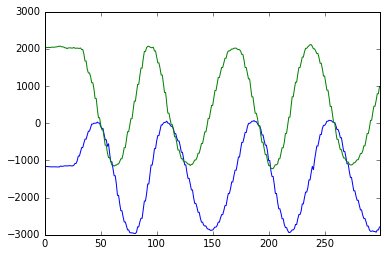

In [8]:
ax = level.mag_x.plot()
level.mag_y.plot(ax=ax)

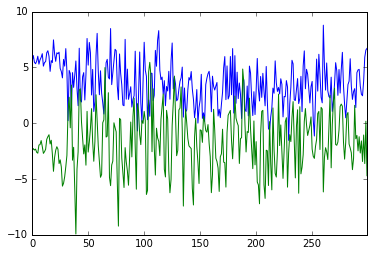

In [19]:
level['pitch'] = np.degrees(np.arctan2(level.acc_x, np.sqrt(level.acc_x**2 + level.acc_z**2)))
level['roll'] = np.degrees(np.arctan2(-level.acc_y, -level.acc_z))
level.pitch.plot()
level.roll.plot()

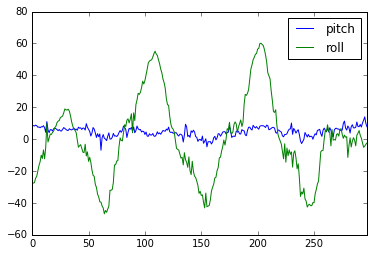

In [22]:
roll['pitch'] = np.degrees(np.arctan2(roll.acc_x, np.sqrt(roll.acc_x**2 + roll.acc_z**2)))
roll['roll'] = np.degrees(np.arctan2(-roll.acc_y, -roll.acc_z))
roll.pitch.plot(legend=True)
roll.roll.plot(legend=True)

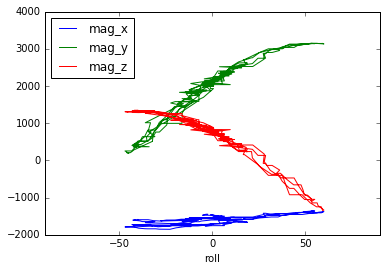

In [27]:
ax = roll.plot('roll', 'mag_x')
roll.plot('roll', 'mag_y', ax=ax)
roll.plot('roll', 'mag_z', ax=ax, xlim=(-90, 90))

In [29]:
offset_x = (level.mag_x.max() + level.mag_x.min())/2
offset_y = (level.mag_y.max() + level.mag_y.min())/2
range_x = level.mag_x.max() - level.mag_x.min()
range_y = level.mag_y.max() - level.mag_y.min()
print(offset_x, range_x, offset_y, range_y)

-1442.0 3044 445.5 3333


In [30]:
y_flat = roll[(-3 < roll.roll) & (roll.roll < +3)]['mag_y'].mean()

# Adjust X and Y fields by calibration already got (dance calibration)
MagX = (roll.mag_x - offset_x) / range_x
MagY = (roll.mag_y - offset_y) / range_y
MagY_flat = (y_flat - offset_y) / range_y
raw_z = roll.mag_z

# Convert pitch and roll to radians for trig functions
roll_r = np.radians(roll.roll)
pitch_r = np.radians(roll.pitch)

def mag_y_comp_residuals(p):
    MagY_comp = (MagX * np.sin(roll_r) * np.sin(pitch_r)) +\
     (MagY * np.cos(roll_r)) - (((raw_z - p[0]) / p[1])* np.sin(roll_r) * np.cos(pitch_r)) 
    return MagY_comp - MagY_flat

In [31]:
from scipy.optimize import leastsq
res, ier = leastsq(mag_y_comp_residuals, (1, 1))
assert 1 <= ier <= 4
res

array([-1016.28084089,  3032.72620884])

In [32]:
MagZ = (raw_z - res[0]) / res[1]

MagY_comp = (MagX * np.sin(roll_r) * np.sin(pitch_r)) +\
    (MagY * np.cos(roll_r)) - (MagZ * np.sin(roll_r) * np.cos(pitch_r))

In [33]:
import matplotlib.pyplot as plt

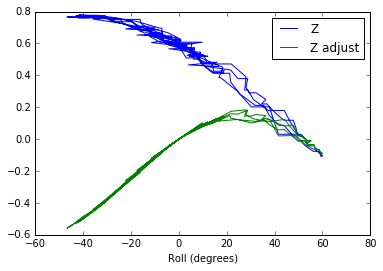

In [35]:
plt.plot(roll.roll, MagZ, label='Z')
plt.plot(roll.roll, MagZ * np.sin(roll_r) * np.cos(pitch_r), label='Z adjust')
plt.xlabel('Roll (degrees)')
plt.legend()

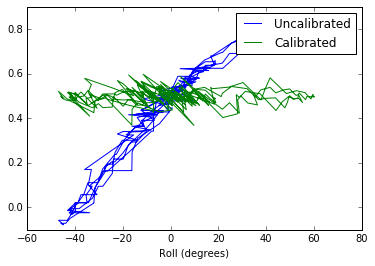

In [36]:
plt.plot(roll.roll, MagY, label='Uncalibrated')
plt.plot(roll.roll, MagY_comp, label='Calibrated')
plt.xlabel('Roll (degrees)')
plt.legend()